## 'Histogram of Oriented Gradients for Owl Detection'

# 1. Implementation

In [1]:
# Import libraries
#from scipy.ndimage import imread
from matplotlib.pyplot import imread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from imp import reload
import hogs
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#%matplotlib inline
from numpy.random import randint
from skimage.transform import rescale, resize

def random_subframes(imgs, rows=192, cols=128, n=1):
#def random_subframes(imgs, rows=96, cols=64, n=1):
    frames = np.zeros([n, rows, cols, 3], dtype='uint8')
    for i in range(0, n//4):
        img = imgs[randint(0, imgs.shape[0])]
        y_loc = randint(0, img.shape[0] - rows)
        x_loc = randint(0, img.shape[1] - cols)
        frames[i, :, :, :] = img[y_loc:y_loc+rows, x_loc:x_loc+cols, :]
    for i in range(n//4, n//2):
        img = imgs[randint(0, imgs.shape[0])]
        y_loc = randint(0, img.shape[0] - rows*2)
        x_loc = randint(0, img.shape[1] - cols*2)
        temp = img[y_loc:y_loc+rows*2, x_loc:x_loc+cols*2, :]
        frames[i, :, :, :] =  cv2.resize(temp, (cols, rows))
    for i in range(n//2, 3*n//4):
        img = imgs[randint(0, imgs.shape[0])]
        y_loc = randint(0, img.shape[0] - rows*4)
        x_loc = randint(0, img.shape[1] - cols*4)
        temp = img[y_loc:y_loc+rows*4, x_loc:x_loc+cols*4, :]
        frames[i, :, :, :] =  cv2.resize(temp, (cols, rows))
    for i in range(3*n//4, n):
        img = imgs[randint(0, imgs.shape[0])]
        y_loc = randint(0, img.shape[0] - rows*8)
        x_loc = randint(0, img.shape[1] - cols*8)
        temp = img[y_loc:y_loc+rows*8, x_loc:x_loc+cols*8, :]
        frames[i, :, :, :] =  cv2.resize(temp, (cols, rows))
    return frames

In [2]:
# Import positive samples
pos_fps = glob.glob('./data/pos_new/*')
pos_samples = np.array([imread(img_fp) for img_fp in pos_fps])
#pos_labels = [fp.split('\\')[-1] for fp in pos_fps]
print(pos_samples.shape)

(1584, 192, 128, 3)


In [3]:
# Import negative samples
neg_fps = glob.glob('./data/neg/*')
neg_imgs = np.array([imread(img_fp) for img_fp in neg_fps])
# Build a large negative training set by subsampling
neg_samples = random_subframes(neg_imgs, n=17000)
print(neg_samples.shape)

(17000, 192, 128, 3)


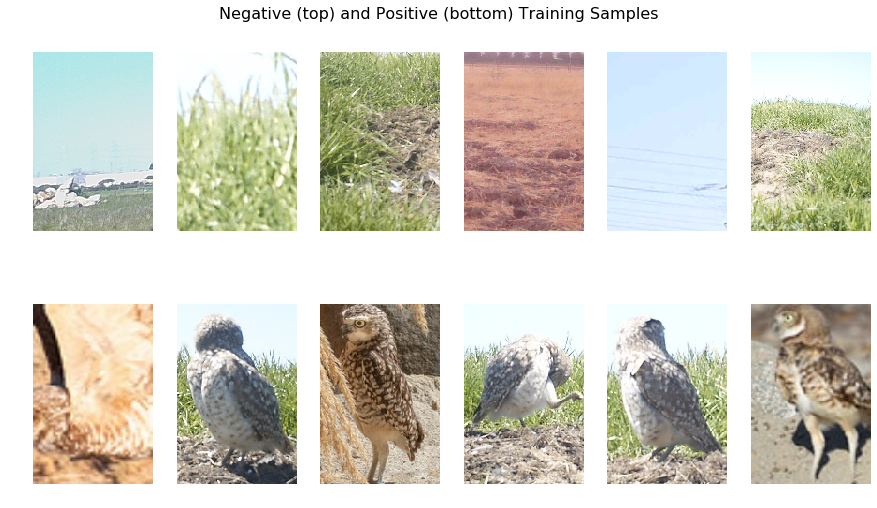

In [4]:
n_plots = 6
f, axs = plt.subplots(2, n_plots, sharey=True, figsize=(15,8))
for i in range(n_plots):
    axs[0, i].imshow(neg_samples[randint(0, len(neg_samples))]); axs[0, i].axis('off');
    axs[1, i].imshow(pos_samples[randint(0, len(pos_samples))]); axs[1, i].axis('off');
plt.suptitle('Negative (top) and Positive (bottom) Training Samples', size=16); plt.subplots_adjust(top=0.93);

In [5]:
pos_d = hogs.Descriptor(pos_samples)
neg_d = hogs.Descriptor(neg_samples)

samples = pd.DataFrame(np.concatenate([pos_d.samples, neg_d.samples]))

responses = pd.Series(np.concatenate([np.ones(len(pos_d.samples)), np.zeros(len(neg_d.samples))]).T)
training_samples, testing_samples, training_responses, testing_responses = train_test_split(samples, responses)
print(testing_samples.shape)

(4646, 12420)


In [6]:
# Model Creation
#svm = LinearSVC()
svm = SVC(kernel='poly', gamma='scale', degree=4)
svm.fit(training_samples, training_responses)
predictions = svm.predict(testing_samples)

In [7]:
# Model Evaluation
print(classification_report(testing_responses, predictions)) # f1-score is harmonic mean of preicison and recall

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      4265
         1.0       0.94      0.78      0.86       381

   micro avg       0.98      0.98      0.98      4646
   macro avg       0.96      0.89      0.92      4646
weighted avg       0.98      0.98      0.98      4646



In [8]:
#AP matrix
print(confusion_matrix(testing_responses, predictions))

[[4246   19]
 [  82  299]]


In [14]:
import pickle
pickle.dump( svm, open( "svm_poly_4.pickle", "wb" ))

## 2. Implementation of a Histogram of Gradients Descriptor

In [10]:
def max_channel_mask(a): # For getting the maximum pixels' mask from a 3D image
    z = np.zeros(a.shape[:2])
    comparator = np.expand_dims(np.argmax(a, axis=2), axis=2)
    mask = (np.stack([z, z+1, z+2], axis=2) == comparator)
    return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


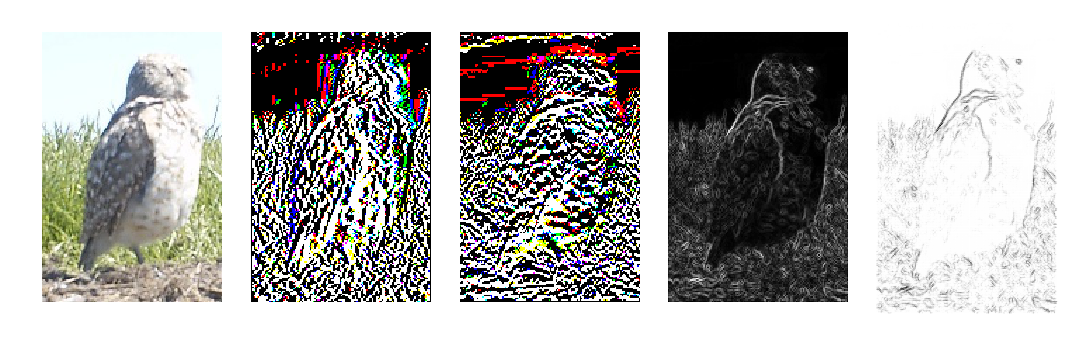

In [11]:
import cv2 
# Demo
# 1. Compute gradient magnitudes + orientations
sample_img = pos_samples[50]
img_rows = sample_img.shape[0]
img_cols = sample_img.shape[1]

xfilter = np.array([[-1, 0, 1]])
yfilter = xfilter.T
xgradients = cv2.filter2D(sample_img.copy().astype('float32'), -1, xfilter)
ygradients = cv2.filter2D(sample_img.copy().astype('float32'), -1, yfilter)
gradmag = np.sqrt(xgradients**2 + ygradients**2) # Take pixels from channel with largest gradient
grador = np.arctan(np.divide(xgradients, ygradients+.00001))# Angle relative to  vertical in radians
mask = max_channel_mask(gradmag)
grador = (grador*mask).sum(axis=2)
gradmag = (gradmag*mask).sum(axis=2)

# For the quiver plot
Y, X = np.mgrid[0:grador.shape[0], 0:grador.shape[1]]
U = gradmag*np.cos(grador) # x component
V = gradmag*np.sin(grador) # y component

_, axs = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(15, 5))

axs[0].imshow(sample_img); axs[1].imshow(xgradients, cmap='gray'); 
axs[2].imshow(ygradients, cmap='gray'); axs[3].imshow(gradmag, cmap='gray');
plt.quiver(X, Y, U, V, gradmag, headwidth=3, headlength=3, pivot='mid', cmap='Greys', axes=axs[4], lw=.15);
_ = [ax.axis('off') for ax in axs]; plt.tight_layout();

# Large quiver plot
#plt.figure(figsize=(15, 30))
#plt.quiver(X, Y, U, V, gradmag, headwidth=3, headlength=3, pivot='mid', cmap='Greys', lw=.15);
#plt.axis('off'); plt.ylim(128, 0); plt.xlim(0, 64);

In [12]:
# 2. Magnitude-weighted voting into histogram bins
bins = np.linspace(-np.pi/2, np.pi/2, 9)
hist_img = np.tile(bins, [img_rows, img_cols, 1])
bin_width = bins[1] - bins[0]
mags = np.expand_dims(gradmag, axis=2)
ors = np.expand_dims(grador, axis=2)
mask = abs(ors - hist_img) < bin_width
hist_img = mask*mags*(1 - abs(ors - hist_img)/bin_width) # Depth contains histogram bin votes for each pixel

# 3. Aggregating votes over 8x8 cells
cell_hist = np.zeros([16, 8, 9])
for row_ix in np.arange(0, 128, 8):
    for col_ix in np.arange(0, 64, 8): # Convolution
        cell_pixels = hist_img[row_ix:row_ix+8, col_ix:col_ix+8, :]
        cell_hist[int(row_ix/8), int(col_ix/8), :] = np.tensordot(cell_pixels, np.ones([8, 8, 1]),
                                                                     axes=((0, 1), (0, 1))).squeeze()

AttributeError: module 'matplotlib.pyplot' has no attribute 'hold'

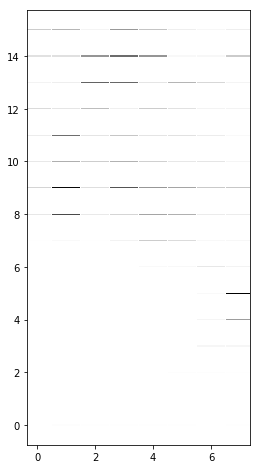

In [13]:
# For the quiver plot
f = plt.figure(figsize=(4, 8), facecolor='white')
U = V = {}
Y, X = np.mgrid[0:cell_hist.shape[0], 0:cell_hist.shape[1]]
for i, th in enumerate(bins):
    V = np.cos(th) # x component
    U = np.sin(th) # y component
    plt.quiver(X, Y, U, V, cell_hist[:, :, i]/cell_hist.max(), pivot='mid',
                   cmap='Greys', scale=8, headaxislength=0, headlength=0, headwidth=1)
    plt.hold('on')
plt.axis('off')
plt.ylim(16, 0);

In [ ]:
# 4. Normalize cells histograms in the context of adjacent cells, then combine these into a descriptor vector.
descriptor = np.zeros([14*6, 81])
for row in range(14):
    for col in range(6):
        block = cell_hist[row:row+3, col:col+3, :].flatten()
        block_descriptor = block/np.linalg.norm(block) #Normalization
        descriptor[row*6 + col, :] = block_descriptor
descriptor = descriptor.flatten()

In [ ]:
np.any(np.isnan(training_samples))